# Prevendo o Futuro

Redes neurais na predição de séries temporais

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-08-22 03:23:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-08-22 03:23:07 (128 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = pd.read_csv('/tmp/sunspots.csv')
series = np.array(dataset.iloc[:,2].astype(np.float32).values)
times = np.array(dataset.iloc[:,0].astype(int).values)

In [38]:
print(series[:10])
print(times[:10])

[ 96.7 104.3 116.7  92.8 141.7 139.2 158.  110.5 126.5 125.8]
[0 1 2 3 4 5 6 7 8 9]


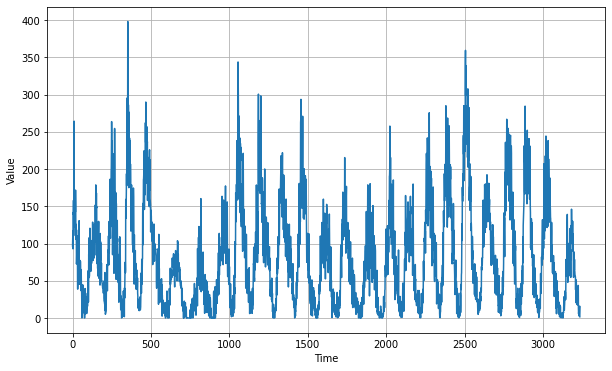

In [39]:
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
  
plt.figure(figsize=(10, 6))
plot_series(times, series)

In [40]:
split_time = 3000
time_train = times[:split_time]
x_train = series[:split_time]
time_valid = times[split_time:]
x_valid = series[split_time:]

In [41]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [42]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>
(3000,)


In [43]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(1))

In [44]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.RMSprop(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])

Epoch 1/150
12/12 [==============================] - 2s 150ms/step - loss: 82.8599 - mae: 83.3496
Epoch 2/150
12/12 [==============================] - 2s 151ms/step - loss: 82.8424 - mae: 83.3319
Epoch 3/150
12/12 [==============================] - 2s 151ms/step - loss: 82.8223 - mae: 83.3116
Epoch 4/150
12/12 [==============================] - 2s 152ms/step - loss: 82.8007 - mae: 83.2898
Epoch 5/150
12/12 [==============================] - 2s 152ms/step - loss: 82.7769 - mae: 83.2659
Epoch 6/150
12/12 [==============================] - 2s 154ms/step - loss: 82.7505 - mae: 83.2393
Epoch 7/150
12/12 [==============================] - 2s 155ms/step - loss: 82.7211 - mae: 83.2096
Epoch 8/150
12/12 [==============================] - 2s 155ms/step - loss: 82.6880 - mae: 83.1764
Epoch 9/150
12/12 [==============================] - 2s 156ms/step - loss: 82.6509 - mae: 83.1393
Epoch 10/150
12/12 [==============================] - 2s 159ms/step - loss: 82.6092 - mae: 83.0979
Epoch 11/150
12/12 

(1e-08, 1.0, 0.0, 90.0)

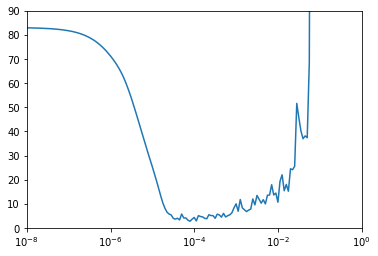

In [45]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 90])

In [46]:
d = dict(zip(history.history["lr"], history.history["loss"]))
mn = min(d, key=d.get)
mn, d[mn]

(7.943282e-05, 2.7997255325317383)

In [47]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(1))
model.compile(loss="mse", optimizer=tf.keras.optimizers.RMSprop(lr=8e-5, momentum=0.9),metrics=["mae"])

In [48]:
history = model.fit(train_set, epochs=500,verbose=1)

Epoch 1/500
12/12 [==============================] - 2s 155ms/step - loss: 8033.7744 - mae: 65.6023
Epoch 2/500
12/12 [==============================] - 2s 161ms/step - loss: 2240.6685 - mae: 30.8147
Epoch 3/500
12/12 [==============================] - 2s 160ms/step - loss: 684.2622 - mae: 17.0309
Epoch 4/500
12/12 [==============================] - 2s 162ms/step - loss: 365.5703 - mae: 13.0712
Epoch 5/500
12/12 [==============================] - 2s 164ms/step - loss: 228.4057 - mae: 10.1430
Epoch 6/500
12/12 [==============================] - 2s 165ms/step - loss: 99.0340 - mae: 5.6971
Epoch 7/500
12/12 [==============================] - 2s 164ms/step - loss: 43.5233 - mae: 3.3399
Epoch 8/500
12/12 [==============================] - 2s 166ms/step - loss: 27.0153 - mae: 2.5109
Epoch 9/500
12/12 [==============================] - 2s 167ms/step - loss: 20.9094 - mae: 2.1693
Epoch 10/500
12/12 [==============================] - 2s 168ms/step - loss: 17.9410 - mae: 1.9192
Epoch 11/500
12/1

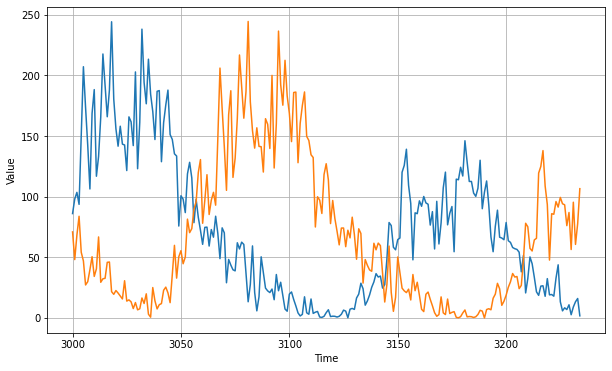

In [49]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

### Mixando modelos

In [50]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [51]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [56]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [52]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 26ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 0s 28ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 0s 27ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 0s 27ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 0s 28ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 0s 27ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 0s 29ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 0s 30ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 0s 32ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [=====

(1e-08, 0.0001, 0.0, 60.0)

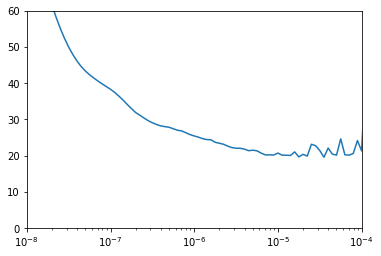

In [53]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [54]:
d = dict(zip(history.history["lr"], history.history["loss"]))
mn = min(d, key=d.get)
mn, d[mn]

(3.548134e-05, 19.51842498779297)

In [55]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 16ms/step - loss: 38.9198 - mae: 39.4161
Epoch 2/500
30/30 [==============================] - 0s 16ms/step - loss: 25.7735 - mae: 26.2680
Epoch 3/500
30/30 [==============================] - 0s 16ms/step - loss: 22.0771 - mae: 22.5709
Epoch 4/500
30/30 [==============================] - 0s 16ms/step - loss: 20.4773 - mae: 20.9702
Epoch 5/500
30/30 [==============================] - 0s 16ms/step - loss: 19.7890 - mae: 20.2815
Epoch 6/500
30/30 [==============================] - 0s 16ms/step - loss: 19.2732 - mae: 19.7654
Epoch 7/500
30/30 [==============================] - 0s 15ms/step - loss: 18.7057 - mae: 19.1979
Epoch 8/500
30/30 [==============================] - 0s 16ms/step - loss: 18.1235 - mae: 18.6151
Epoch 9/500
30/30 [==============================] - 0s 16ms/step - loss: 18.1309 - mae: 18.6225
Epoch 10/500
30/30 [==============================] - 0s 16ms/step - loss: 20.0976 - mae: 20.5900
Epoch 11/500
30/30 [=========

In [57]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

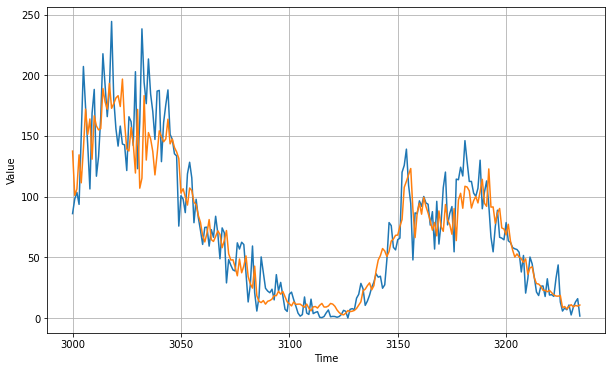

In [58]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [59]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.597435